# Sparse Autoencoder

In [151]:
import sklearn as sk
import numpy as np
import pandas as pd
import time
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
import theano.tensor as th
from scipy import misc
import copy
from numpy.random import uniform
from numpy.random import normal
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from math import copysign

import matplotlib.pylab as plt
%matplotlib inline

In [152]:
class autoencoder:
    def __init__(self, layers_list, learning_rate, alpha, activation_functions, cost_func, mode, \
                 cou_iter, early_stop, regularization, reg_param, batch_size, prob, reg_val_for_prob):
        self.layers_count = len(layers_list)
        self.weight_list = []
        self.learning_rate = learning_rate
        self.layers_list = layers_list
        self.alpha = alpha
        self.cost_func = cost_func
        self.activation_functions = activation_functions
        self.mode = mode
        self.batch_size = batch_size
        self.cou_iter = cou_iter
        self.early_stop = early_stop
        self.regularization = regularization
        self.reg_param = reg_param
        self.prob = prob
        self.reg_prob = reg_val_for_prob
        for i in range(1, self.layers_count):
            m = np.asarray(normal(0, 0.1, (self.layers_list[i - 1] + 1, self.layers_list[i])))
            self.weight_list.append(m)
            
    
    def sigmoid(self, x):
        one = np.ones(len(x))
        val = one / (one + np.exp(-x * self.alpha))
        for i in range(len(val)):
            if (val[i] == 0):
                val[i] = 0.00001
            elif (val[i] == 1):
                val[i] = 0.99999
        return one / (one + np.exp(-x * self.alpha))
    
    def sigmoid_for_matrix(self, x):
        one = np.ones((x.shape[0], x.shape[1]))
        return one / (one + np.exp(-x * self.alpha))
        
    
    def der_sigmoid(self, x):
        one = np.ones(len(x))
        return (one - self.sigmoid(x)) * self.sigmoid(x) * self.alpha
    
    def x(self, x):
        return x
    
    def der_x(self, x):
        return np.ones(len(x))
    
    def hyp_tg(self, x):
        return (np.exp(self.alpha * x) - np.exp(-self.alpha * x)) / (np.exp(self.alpha * x) + np.exp(-self.alpha * x))
    
    def der_hyp_tg(self, x):
        return self.alpha * (1 - (self.hyp_tg(x)) ** 2)
    
    def add_two_lists(self, l1, l2):
        for pos in range(len(l1)):
            l1[pos] += l2[pos]
        return l1
    
    def div_list(self, l1, m):
        for pos in range(len(l1)):
            l1[pos] /= m
        return l1
    
    def square_cost(self, y_true, y_pred):
        return  0.5*((y_true - y_pred) ** 2.0)
    
    def der_square_cost(self, y_true, y_pred):
        return (y_pred - y_true)
    
    def add_first_layer(self, x_shape):
        self.weight_list.insert(0, np.asarray(normal(0, 0.1, (x_shape, self.layers_list[0]))))
        
    def get_distribution(self, sample):
        return np.dot(self.weight_list[0].T, sample)
    
    def predict(self, x):
        x = np.asarray(x)
        x = np.insert(x, 0, [-1], axis = 1)
        ans = []
        for s_num, sample in enumerate(x):
            v = sample
            for num, layer in enumerate(self.weight_list):
                v = np.dot(layer.T, v)
                if (self.activation_functions[num] == 'sigmoid'):
                    v = self.sigmoid(v)
                elif (self.activation_functions[num] == 'hyp_tg'):
                    v = self.hyp_tg(v)
                elif (self.activation_functions[num] == 'x'):
                    v = self.x(v)
                if (num != self.layers_count - 1):
                    v = np.insert(v, 0, [-1])
            if (self.mode == 'autoencoder'):
                ans.append(v)
        ans = np.asarray(ans)
        return ans
    
    def get_error(self, x):
        y_pred = self.predict(x)
        y_err = np.sum((y_pred - x) ** 2) / len(y_pred)
        return y_err
    
    def der_prob(self, aposteriori_prob):
        one = np.ones(len(aposteriori_prob))
        apriori_prob = one * self.prob
        return (aposteriori_prob - apriori_prob) / ((one - aposteriori_prob) * aposteriori_prob)
    
    def fit(self, x, y):
        y = np.asarray(y)
        x = np.insert(np.asarray(x), 0, -1, axis = 1)
        self.add_first_layer(x.shape[1])
        k = 0
        total_err = np.inf
        x_size = len(x)
        ind_frag = x_size * 0.95
        x, y = shuffle(x, y)
        test_x = x[ind_frag:]
        test_y = y[ind_frag:]
        x_new = x[:ind_frag]
        y_new = y[:ind_frag]
        err_arr = []
        result_matrix = []
        hidden_layer_add = []
        while (k < self.cou_iter):
            print k, total_err
            total_err = 0.0
            x_new, y_new = shuffle(x_new, y_new)
            balance = self.batch_size
            #print np.dot(self.weight_list[0].T, x_new[:self.batch_size].T)
            #print self.sigmoid_for_matrix(np.dot(self.weight_list[0].T, x_new[:self.batch_size].T))
            #print np.sum(self.sigmoid_for_matrix(np.dot(self.weight_list[0].T, x_new[:self.batch_size].T)), axis = 1)
            #return 0
            hidden_layer_add = self.der_prob(np.sum(self.sigmoid_for_matrix(np.dot(self.weight_list[0].T, x_new[:self.batch_size].T)), axis = 1) / self.batch_size)

            for s_num, sample in enumerate(x_new):
                now_matrix = []      
                if (balance == 0):
                    balance = self.batch_size
                    self.weight_list = self.add_two_lists(self.weight_list, self.div_list(result_matrix, self.batch_size))
                    result_matrix = []
                    if (len(x_new) - s_num < self.batch_size):
                        break
                    hidden_layer_add = self.der_prob(np.sum(self.sigmoid_for_matrix(np.dot(self.weight_list[0].T, x_new[s_num:s_num + self.batch_size].T)), axis = 1) / self.batch_size)
                
                neuron_sum = []
                neuron_out = []
                neuron_out.append(np.asarray(sample, dtype = np.float))
                v = sample
                for num, layer in enumerate(self.weight_list):
                    v = np.dot(layer.T, v)
                    neuron_sum.append(v)
                    if (self.activation_functions[num] == 'sigmoid'):
                        v = self.sigmoid(v)
                    elif (self.activation_functions[num] == 'hyp_tg'):
                        v = self.hyp_tg(v)
                    elif(self.activation_functions[num] == 'x'):
                        v = self.x(v) 
                    if (num != self.layers_count - 1):
                        v = np.insert(v, 0, [-1])
                    neuron_out.append(v)
                   
                der_neuron = []
                if (self.cost_func == 'square' and self.activation_functions[-1] == "x"):
                    der_neuron = [(self.der_square_cost(y_new[s_num], neuron_out[-1]) * self.der_x(neuron_sum[-1]))]
                
                num = 1
                for layer in reversed(self.weight_list[1:]):
                    if (self.activation_functions[self.layers_count - num - 1] == 'sigmoid'):
                        der_neuron.insert(0, (np.dot(layer[1:], der_neuron[0]) + self.reg_prob* hidden_layer_add) * self.der_sigmoid(neuron_sum[len(neuron_sum) - num - 1]))
                    elif (self.activation_functions[self.layers_count - num - 1] == 'hyp_tg'):
                        der_neuron.insert(0, (np.dot(layer[1:], der_neuron[0]) + self.reg_prob* hidden_layer_add) * self.der_hyp_tg(neuron_sum[len(neuron_sum) - num - 1]))
                    num += 1

                for layer_num in range(self.layers_count):
                    if (self.regularization == 'l2'):
                        now_matrix.insert(0, -1.0*self.learning_rate* (np.dot(neuron_out[len(neuron_out) - layer_num - 2].T.reshape(-1, 1), der_neuron[len(der_neuron) - layer_num - 1].reshape(1, -1))+\
                                                                   self.reg_param * self.weight_list[self.layers_count - layer_num - 1]))
                    elif (self.regularization == 'l1'):
                        now_matrix.insert(0, -1.0*self.learning_rate* (np.dot(neuron_out[len(neuron_out) - layer_num - 2].T.reshape(-1, 1), der_neuron[len(der_neuron) - layer_num - 1].reshape(1, -1))+\
                                                                   self.reg_param * np.sign(self.weight_list[self.layers_count - layer_num - 1])))
                        
                if (len(result_matrix) == 0):
                    result_matrix = list(now_matrix)
                else:
                    result_matrix = self.add_two_lists(result_matrix, now_matrix)
                balance -= 1
                
            k += 1
            if (self.mode == 'autoencoder'):
                total_err = self.get_error(test_x[:, 1:])


# Read Data

In [153]:
im = misc.imread('data/big_alphabet_29x29/mutant-0-0-0.bmp', flatten='grey')
alphabet_size = 26
im_size = 29

In [154]:
x = []
y = []
x_test = []
y_test = []
for letter in range(alphabet_size):
    for i in range(9):
        path = "data/big_alphabet_29x29/mutant-" + str(letter) + "-" + str(i) + "-0.bmp"
        im = misc.imread(path, flatten='grey')
        #if (i == 0 or i == 1):
         #   x_test.append(im.reshape(im_size * im_size))
        #  x_test[-1] /= 255
        #else:
        x.append(im.reshape(im_size * im_size))
        x[-1] /= 255.0

for letter in range(alphabet_size):
    path = "data/big_alphabet_29x29/class-" + str(letter) + ".bmp"
    im = misc.imread(path, flatten='grey')
    x_test.append(im.reshape(im_size * im_size))
    x_test[-1] /= 255

    
x = np.asarray(x)
y = x.copy()
x_test = np.asarray(x_test)
y_test = x_test.copy()

In [155]:
print x.shape, y.shape

(234, 841) (234, 841)


In [156]:
nt = autoencoder(layers_list=[alphabet_size + 20, im_size * im_size], learning_rate=0.002, alpha=1.5, \
             activation_functions=['sigmoid', 'x'], cost_func="square", \
             mode='autoencoder', cou_iter=1500, early_stop=-1, regularization = 'l2', reg_param = 0.000, batch_size = 25,\
                prob = 0.04, reg_val_for_prob = 0.6)
nt.fit(x, y)

ypred = nt.predict(x_test)
print np.sum((ypred - y_test)**2) / len(ypred)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:116: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:117: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:118: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:119: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0 inf
1 663.663478429
2 484.94033936
3 307.472429274
4 192.073193752
5 130.783989625
6 100.141640386
7 80.0036497942
8 72.162318948
9 64.3626377447
10 56.9730434212
11 55.7339050784
12 57.1293866531
13 55.7397484397
14 55.9183680119
15 56.5913539217
16 61.0889455099
17 55.3327306505
18 55.8896499799
19 58.1916602302
20 72.9348277605
21 57.6892027802
22 71.2498308535
23 73.3951351485
24 67.0089569502
25 69.5059946649
26 66.8341735869
27 67.8445985454
28 76.7158696763
29 82.452113771
30 55.7545271906
31 57.9474101348
32 76.4508849378
33 56.0376553829
34 59.7342933503
35 67.1597682639
36 95.146247529
37 58.2611872173
38 78.1465780948
39 77.0467815633
40 65.9983770279
41 58.5804955487
42 70.5047381403
43 58.7345407235
44 79.5913942475
45 70.8820015544
46 68.2994592484
47 70.8988204165
48 56.6355670171
49 58.3563836949
50 61.0306327772
51 66.4509222343
52 64.8954748073
53 66.013412918
54 59.3134960959
55 65.1540729528
56 76.112475252
57 82.219877341
58 83.9923049244
59 54.8494646754
60 55.3

13.7136978961


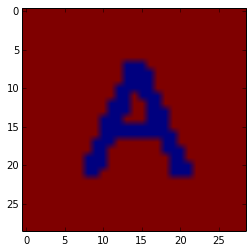

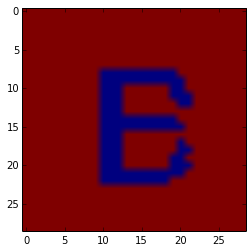

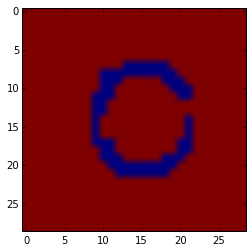

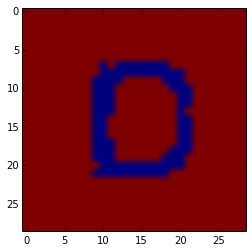

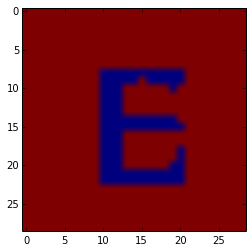

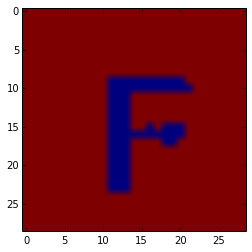

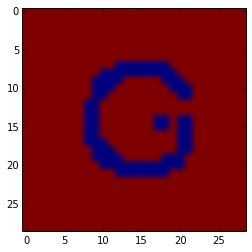

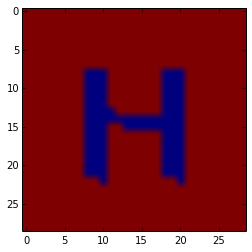

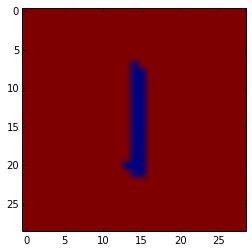

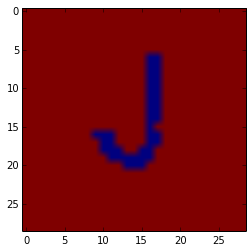

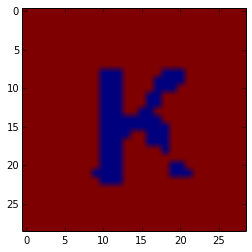

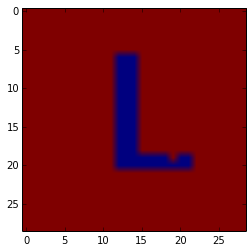

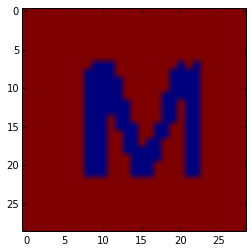

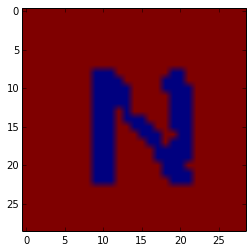

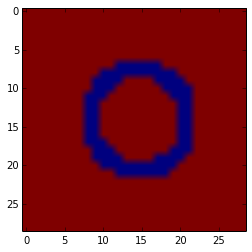

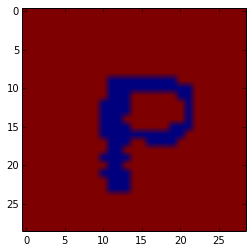

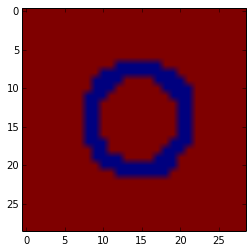

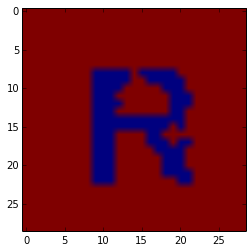

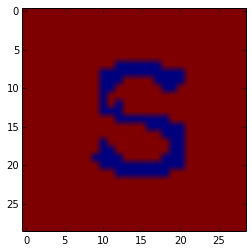

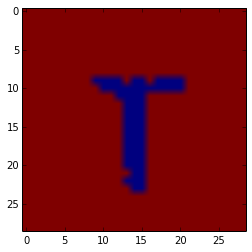

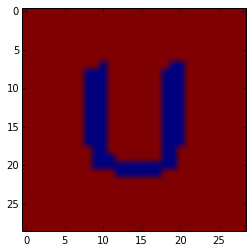

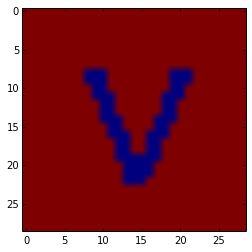

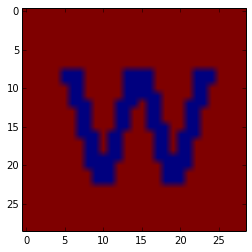

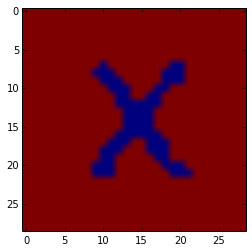

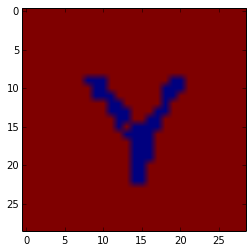

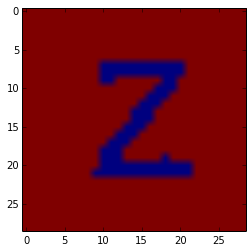

In [157]:
print np.sum((ypred - y_test)**2) / len(ypred)
for j in range(len(ypred)):
    f = ypred[j].copy()
    f = f.reshape((im_size, im_size))
    for i in range(29):
        for j in range(29):
            if (f[i][j] >= 0.5):
                f[i][j] = 255.
            else:
                f[i][j] = 0.
    plt.imshow(f)
    plt.show()


In [158]:
y_y = np.insert(ypred, 0, -1, axis = 1)
v = []
for i in range(len(y_y)):
    #print nt.sigmoid(np.dot(nt.weight_list[0].T, y_y[i]))
    v.append(nt.sigmoid(np.dot(nt.weight_list[0].T, y_y[i])))

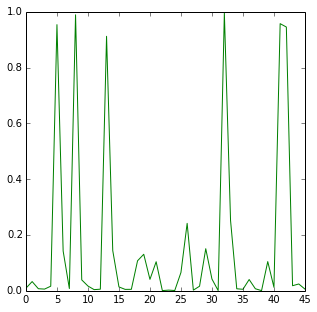

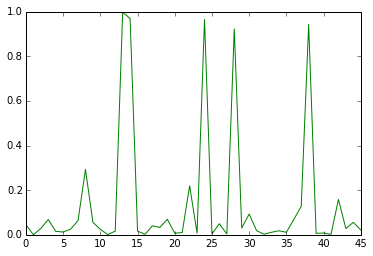

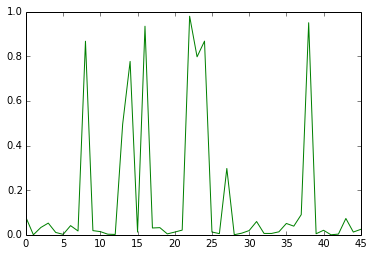

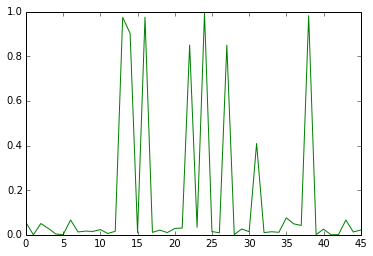

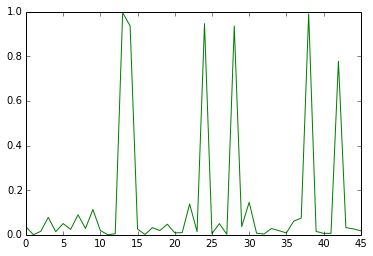

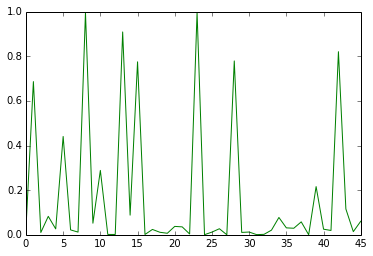

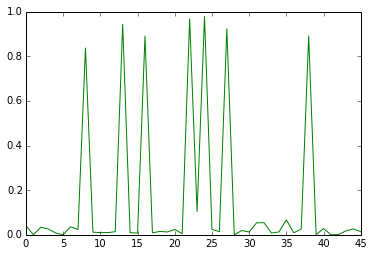

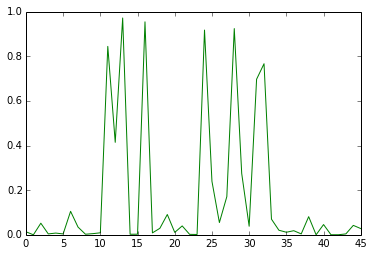

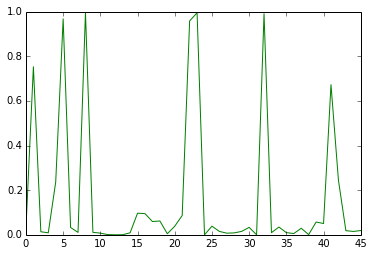

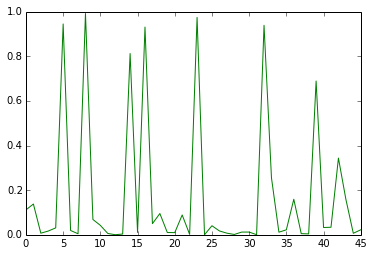

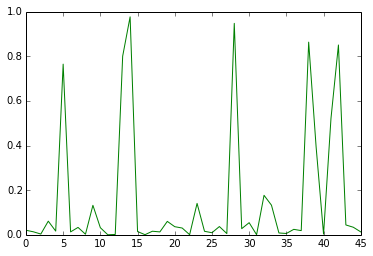

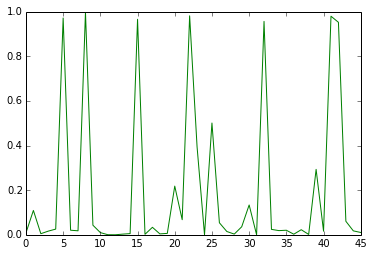

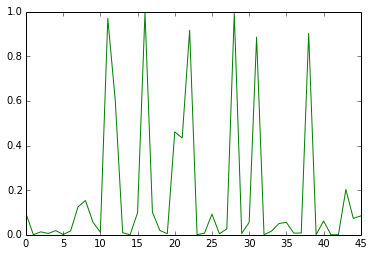

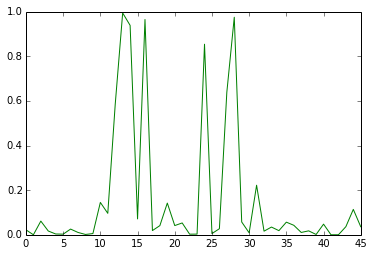

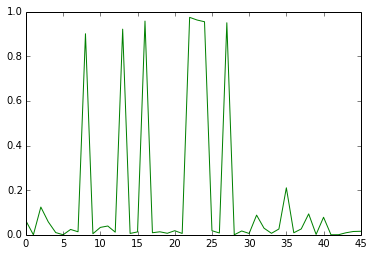

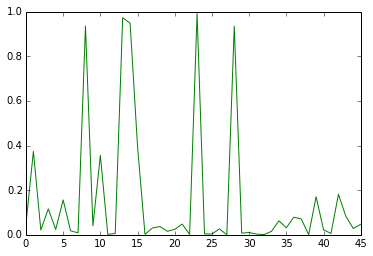

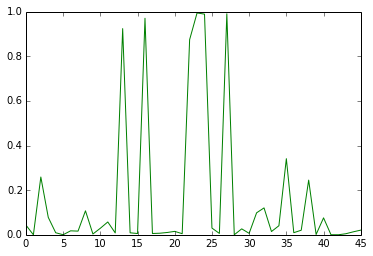

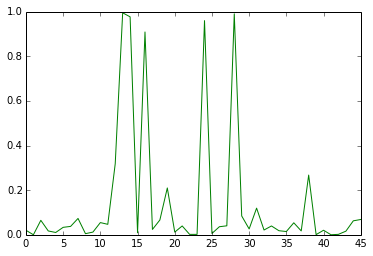

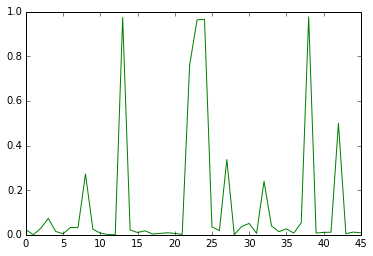

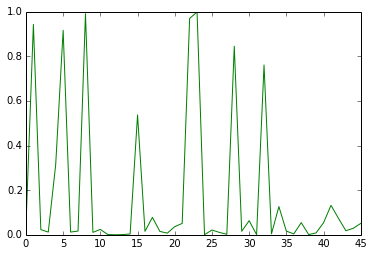

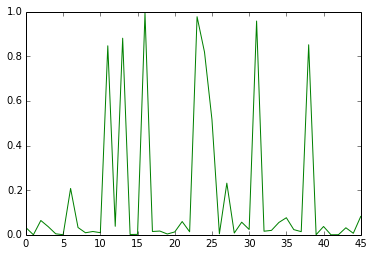

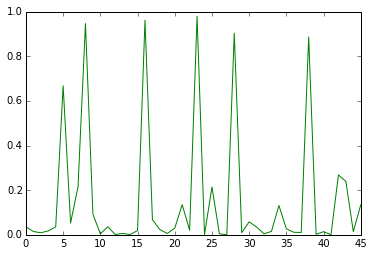

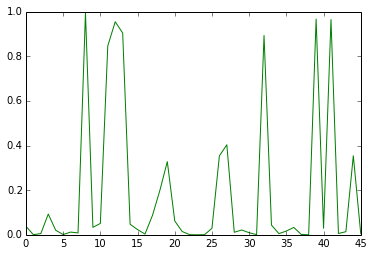

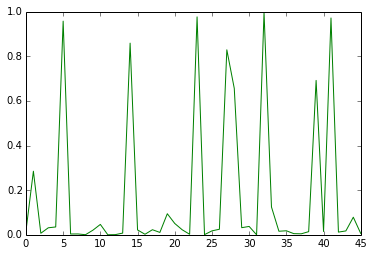

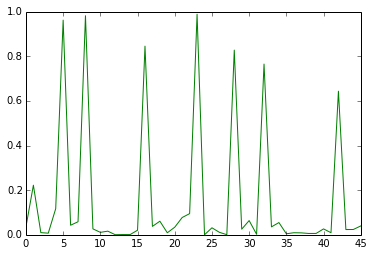

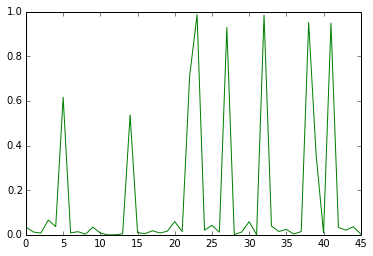

In [159]:
x = np.arange(46)
plt.figure(figsize = (5,5), dpi = 80)
for i in range(len(v)):
    plt.plot(x, v[i], c ='g')
    plt.show()